In [1]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 3.9 MB/s 
     |████████████████████████████████| 3.5 MB 37.2 MB/s 
     |████████████████████████████████| 2.3 MB 38.9 MB/s 
     |████████████████████████████████| 747 kB 22.5 MB/s 
     |████████████████████████████████| 370 kB 4.4 MB/s 
     |████████████████████████████████| 482 kB 46.6 MB/s 
     |████████████████████████████████| 41 kB 565 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=5d2fd8136bb1bf36d664d18bdb2b5bf9700c5cce1a136b799f02692d0839b909
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric


In [2]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re

import csv

In [3]:

### A simple Message-Passing network w/ common aggregation schemes.
class Simple_GNN(torch.nn.Module):

    def __init__(self,in_features,int_features,out_features,depth,aggregation_mode = 'mean',dropout_prob = .1):
        '''
        [in_features]       - # of input features.
        [int_features]      - # of features in message-passing layers. Within the 
                              GNN literature, this is typically a constant.
        [out_features]      - # of output features. Corresponds to # of classes,
                              regression targets, etc.
        [depth]             - # of message-passing layers. 
        [aggregation_mode]  - choice of aggregation scheme. Can be 'mean',
                              'sum', 'max', or 'none'
        [dropout_prob]      - probability used for Dropout (see Srivastava et al., 2017)
        '''

        super(Simple_GNN,self).__init__()
        assert aggregation_mode in ['mean','sum','max','none']

        self.f_in = torch.nn.Linear(in_features,int_features)
        self.f_int = torch.nn.ModuleList([torch.nn.Sequential(*[torch.nn.Linear(int_features,int_features),
                                                                torch.nn.LeakyReLU(),
                                                                torch.nn.Dropout(dropout_prob)])
                                              for _ in range(depth)])
        self.f_out = torch.nn.Linear(int_features,out_features)

        if aggregation_mode == 'mean': self.agg = torch_scatter.scatter_mean
        elif aggregation_mode == 'sum': self.agg = torch_scatter.scatter_sum
        elif aggregation_mode == 'max': self.agg = torch_scatter.scatter_max

        self.aggregation_mode = aggregation_mode

    def forward(self,node_features,edge_index,edge_weights = None):
        '''
        [node_features]  - Matrix of node features. First (batch) dimension corresponds
                           to nodes; second to features.
        [edge_index]     - Edge list representation of a graph. Shape [num_edges]x2
        [edge_weights]   - Optional scalar edge weights. Shape [num_edges,1]
        '''

        node_features = self.f_in(node_features)
        for idx,layer in enumerate(self.f_int):
            if self.aggregation_mode is not 'none':
                if edge_weights is not None:
                    aggregated_node_features = self.agg(edge_weights * node_features[edge_index[:,0]],
                                                                    edge_index[:,1],dim=0)
                else:
                    aggregated_node_features = self.agg(node_features[edge_index[:,0]],edge_index[:,1],dim=0) 
            else:
                aggregated_node_features = node_features
                
            if isinstance(aggregated_node_features,tuple): 
                aggregated_node_features = aggregated_node_features[0]

            node_features = node_features + layer(aggregated_node_features)
        return self.f_out(node_features),node_features

In [4]:
### General purpose object for storing graph data
class Graph(object):
    def __init__(self,edge_index = None,edge_metadata = None,node_metadata = None):
        self.edge_index = edge_index
        self.edge_metadata = edge_metadata
        self.node_metadata = node_metadata
        self.num_nodes = None

    def read_edges(self,filepath):
        ''' Edges should be stored as follows:
            0 1 3.1 2.0
            0 2 1.0 0.0
            1 0 3.1 2.0
            ...
        where the first two columns are node indices and the remainder
        are edge features. '''

        with open(filepath,'r') as f:
          edges = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
        if edges.shape[1] == 2:
          self.edge_index = edges.long()
        elif edges.shape[1] >= 3:
          self.edge_index = edges[:,:2].long()
          self.edge_metadata = edges[:,2::]
                      
    def read_node_metadata(self,filepath,padding_value = 0.0):
        ''' Nodes should be stored as follows:
            0 4.1 9.2 1.1 ...
            2 3.3 1.1 9.0 ...
            ...
        where the first column is the node index and the remainder
        are node features. If a node is not listed but should still 
        clearly exist (e.g, nodes '0' and '2' are present in the file
        but not node '1'), the missing node is given constant features 
        set to [padding_value]'''

        with open(filepath,'r') as f:
          nodes = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
          
        self.num_nodes = 1 + nodes[:,0].max().long()
        node_metadata = padding_value * torch.ones((self.num_nodes,nodes.shape[1]-1))
        node_metadata[nodes[:,0].long()] = nodes[:,1::]   #GE

        self.node_metadata = node_metadata

In [5]:
### Dataset consisting of multiple _Graph_ objects
class GraphsDataset(object):
    ''' Graph metadata is expected to be saved 
        under [graph_dir]/[...]/edges.txt and
        [graph_dir]/[...]/nodes.txt.
    ******* Optional Arguments *********
    [add_self_loops] - Add self loop to each graph. 
                       This tends to improve importance,
                       and it resolves issues with 
                       disconnected nodes.
    '''
    def __init__(self,graph_dir,add_self_loops = True):
        self.root = graph_dir
        self.graphs = os.listdir(graph_dir)
        self.add_self_loops = add_self_loops
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self,idx):
        G = Graph()
        G.read_edges(self.root + '/' + self.graphs[idx]+'/edges.txt')
        G.read_node_metadata(self.root + '/' + self.graphs[idx]+'/nodes.txt')

        if self.add_self_loops:
            self_loops = torch.cat((torch.arange(G.num_nodes)[:,None],torch.arange(G.num_nodes)[:,None]),dim=-1)
            G.edge_index = torch.cat((G.edge_index,self_loops),dim=0)
            G.edge_metadata = torch.cat((G.edge_metadata,torch.ones((G.num_nodes,1))),dim=0)
        return G 

### Helper function to construct batches of graphs. We assume the user wants to
### perform graph-level tasks, and so our target variable is chosen as
### G.node_metadata[0,0] i.e, the first feature of the first node.
def collate_fn(data):
    c,n = 0,0
    for idx,G in enumerate(data):
        if idx == 0: 
            X,Y = G.node_metadata[:,1::],G.node_metadata[0,0][None]
            edge_index,edge_weights = G.edge_index,G.edge_metadata
            batch_index = c * torch.ones(G.num_nodes)
        else:
            X = torch.cat((X,G.node_metadata[:,1::]),dim=0)
            Y = torch.cat((Y,G.node_metadata[0,0][None]),dim=0)

            edge_index = torch.cat((edge_index,n + G.edge_index),dim=0)
            edge_weights = torch.cat((edge_weights,G.edge_metadata),dim=0)
            batch_index = torch.cat((batch_index,c * torch.ones(G.num_nodes)),dim=0)
        n += G.num_nodes
        c += 1

    return {'X':X,'edge_index':edge_index,'edge_weights':edge_weights,'Y':Y.long(),'batch_index':batch_index.long()}

In [6]:
### Call to fit node-level model and save results
class GNN_Node_Trainer(object):
    def __init__(self,graph,**kwargs):
        '''
        [graph]  - Instance of _Graph_. Expects to be fully initialized. 
        ******* Optional Arguments *********
        [train_index],[test_index] - Partitions graph into train and test sets.
                                     Defaults to random 60%/40% split.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy.
        [random_seed]              - Defaults to 0. 
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graph,Graph)        
        self.graph = graph

        ### If train_index and test_index are not provided, we randomly
        ### select a train/test split.
        r = torch.randperm(graph.num_nodes)
        self.train_index,self.test_index = kwargs.get('train_index',r[:int(.6 * len(r))]),\
                                  kwargs.get('test_index',r[int(.6 * len(r))::])

        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume the first column of 'self.graph.node_metedata' to be our 
        target values.
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)

        ### Load data to device.
        node_features,edge_index,edge_weights = self.graph.node_metadata.to(device),\
                                                    self.graph.edge_index.to(device),\
                                                    self.graph.edge_metadata.to(device)
        X,Y = node_features[:,1::].to(device),node_features[:,0].to(device)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        for idx in pbar:
            ### Get predictions and compute losses over train and test sets.
            predictions,_ = model(X,edge_index,edge_weights)
            train_loss,test_loss = self.loss_func(predictions[self.train_index],Y[self.train_index],
                                                  edge_index,edge_weights),\
                                          self.loss_func(predictions[self.test_index],Y[self.test_index],
                                                  edge_index,edge_weights)

            pbar.set_description(f'Train Loss: {train_loss.item():.3f}\tTest Loss: {test_loss.item():.3f}')
            if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

            ### Backpropagate w.r.t training loss
            train_loss.backward()
            opt.step()
            opt.zero_grad()

            ### Save losses and compute additional metrics
            metrics['train_loss'].append(train_loss.item())
            metrics['test_loss'].append(test_loss.item())
            for key in metrics_callback.keys():
                metrics['train_'+key].append(metrics_callback[key](predictions[self.train_index],Y[self.train_index],
                                                        edge_index,edge_weights))
                metrics['test_'+key].append(metrics_callback[key](predictions[self.test_index],Y[self.test_index],
                                                        edge_index,edge_weights))

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))

        return predictions

In [7]:
### Call to fit graph-level model and save results
class GNN_Graph_Trainer(object):
    def __init__(self,graphs,collate_fn,**kwargs):
        '''
        [graphs]      - Instance of _GraphsDataset_. Expects to be fully initialized. 
        [collate_fn]  - Collate function for batching purposes.
        ******* Optional Arguments *********
        [batch_size]               - Number of graphs per train/val batch. Defaults
                                     to 50.
        [train_%]                  - Pct. split into train set. Defaults to 80%/20%.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy. 
        [random_seed]              - Defaults to 0.
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graphs,GraphsDataset)
        self.graphs = graphs
        self.collate_fn = collate_fn

        self.train_pct = kwargs.get('train_%',.8)

        self.batch_size = kwargs.get('batch_size',50)
        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume 'self.graphs[idx].node_metedata[0,0]' 
        to be our target value for all idx \in [0,len(self.graphs)] .
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)
        
        ### Generate train/test split.
        train,test = torch.utils.data.random_split(self.graphs,[int(len(self.graphs) * self.train_pct),
                                                               len(self.graphs) - int(len(self.graphs) * self.train_pct)]
                                                  )
        train_loader,test_loader = torch.utils.data.DataLoader(train,batch_size=self.batch_size,shuffle=True,collate_fn=self.collate_fn),\
                              torch.utils.data.DataLoader(test,batch_size=self.batch_size,shuffle=True,collate_fn=self.collate_fn)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        for idx in pbar:

            ### Training loop
            model.train()
            for data in train_loader:
                X,Y,edge_index,edge_weights,batch_index = data['X'].to(device),data['Y'].to(device),data['edge_index'].to(device),\
                                                              data['edge_weights'].to(device),data['batch_index'].to(device)

                predictions,_ = model(X,edge_index,edge_weights)
                ### To keep things simple, we employ mean READOUT to produce a global
                ### graph embedding. 
                train_loss = self.loss_func(torch_scatter.scatter_mean(predictions,batch_index,dim=0),Y,edge_index,edge_weights)

                pbar.set_description(f'Train Loss: {train_loss.item():.3f}')
                if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

                train_loss.backward()
                opt.step()
                opt.zero_grad()

                ### Compute and save metrics.
                metrics['train_loss'].append(train_loss.item())
                for key in metrics_callback.keys():
                        metrics['train_'+key].append(metrics_callback[key](torch_scatter.scatter_mean(predictions,batch_index,dim=0),
                                                                    Y,edge_index,edge_weights))
                        
            ### Evaluation loop. 
            model.eval()
            with torch.no_grad():
                for data in test_loader:
                    X,Y,edge_index,edge_weights,batch_index = data['X'].to(device),data['Y'].to(device),data['edge_index'].to(device),\
                                                              data['edge_weights'].to(device),data['batch_index'].to(device)

                    predictions,_ = model(X,edge_index,edge_weights)
                    train_loss = self.loss_func(torch_scatter.scatter_mean(predictions,batch_index,dim=0),Y,edge_index,edge_weights)

                    pbar.set_description(f'Test Loss: {train_loss.item():.3f}')

                    metrics['test_loss'].append(train_loss.item())
                    for key in metrics_callback.keys():
                          metrics['test_'+key].append(metrics_callback[key](torch_scatter.scatter_mean(predictions,batch_index,dim=0),
                                                                    Y,edge_index,edge_weights))

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))

        return predictions

In [8]:
path = "/content/drive/MyDrive/output7_new_sentiment.csv"
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#emails = np.genfromtxt(path,dtype=None,names=True,usecols=np.arange(0,1434),skip_header=n)
emails = pd.read_csv(path)

In [ ]:
display(emails.iloc[0])

Unnamed: 0                                                            0
From                       ('cindy', 'dick', 'cynthia.dick@talgov.com')
Sent                                                2011-08-18 12:12:00
To                          [('fire', 'department', 'fire_department')]
CC                                                                   []
Subject                                                              []
Attachments                                                          []
Importance                                                           []
Body                  ['I recently came across this quote and reflec...
textblob_sentiment                         [0.275, 0.39583333333333337]
nltk_sentiment                               [0.0, 0.149, 0.701, 0.149]
flair_sentiment                                       POSITIVE (0.9575)
GCP_sentiment         [0.30000001192092896, 1.7999999523162842, 0.02...
Name: 0, dtype: object

In [ ]:
emails_2011_08 = emails.loc[0:1]
display(emails_2011_08)
display(type(emails_2011_08))

,Unnamed: 0,From,Sent,To,CC,Subject,Attachments,Importance,Body,textblob_sentiment,nltk_sentiment,flair_sentiment,GCP_sentiment
0,0,"('cindy', 'dick', 'cynthia.dick@talgov.com')",2011-08-18 12:12:00,"[('fire', 'department', 'fire_department')]",[],[],[],[],['I recently came across this quote and reflec...,"[0.275, 0.39583333333333337]","[0.0, 0.149, 0.701, 0.149]",POSITIVE (0.9575),"[0.30000001192092896, 1.7999999523162842, 0.02..."
1,1,"('mark', 'decarlo', 'mark.decarlo@talgov.com')",2011-08-20 03:44:00,"[('fire', 'department', 'fire_department')]",[],[],[],[],[''],"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",empty body,"[0.0, 0.0, 0.0]"


pandas.core.frame.DataFrame

In [ ]:
Gr = nx.Graph()

In [ ]:
Gr.add_nodes_from([0,1])

In [ ]:
display(Gr.nodes())

NodeView((0, 1))

In [ ]:
print(emails_2011_08.columns)

Index(['Unnamed: 0', 'From', 'Sent', 'To', 'CC', 'Subject', 'Attachments',
       'Importance', 'Body', 'textblob_sentiment', 'nltk_sentiment',
       'flair_sentiment', 'GCP_sentiment'],
      dtype='object')


In [ ]:
dict_email = emails_2011_08.to_dict()
print(dict_email.get('From'))
sent_people_node = {'Unnamed: 0':'-1', 'From': [], 'Sent': [], 'To': [], 'CC': [], 'Subject': [], 'Attachments': [], 'Importance': [],
                    'Body': [], 'textblob_sentiment': [], 'nltk_setiment': [], 'flair_sentiment': [], 'GCP_sentiment': []}
emails_2011_08_2 = emails_2011_08
emails_2011_08_2.append(sent_people_node, ignore_index=True)
display(emails_2011_08)


{0: "('cindy', 'dick', 'cynthia.dick@talgov.com')", 1: "('mark', 'decarlo', 'mark.decarlo@talgov.com')"}


,Unnamed: 0,From,Sent,To,CC,Subject,Attachments,Importance,Body,textblob_sentiment,nltk_sentiment,flair_sentiment,GCP_sentiment
0,0,"('cindy', 'dick', 'cynthia.dick@talgov.com')",2011-08-18 12:12:00,"[('fire', 'department', 'fire_department')]",[],[],[],[],['I recently came across this quote and reflec...,"[0.275, 0.39583333333333337]","[0.0, 0.149, 0.701, 0.149]",POSITIVE (0.9575),"[0.30000001192092896, 1.7999999523162842, 0.02..."
1,1,"('mark', 'decarlo', 'mark.decarlo@talgov.com')",2011-08-20 03:44:00,"[('fire', 'department', 'fire_department')]",[],[],[],[],[''],"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",empty body,"[0.0, 0.0, 0.0]"


In [ ]:
len(dict_email.get('From', '0'))
d = dict_email.get('From')
display(len(d))
ds = list(d[1].split('()'))

display(len(ds))
display(type(d))



2

1

dict

In [ ]:
with open('nodes.txt','w') as f:
  emails_2011_08.to_csv('/content/drive/MyDrive/nodes.txt', header=None, index=None, sep=' ', mode='a')

In [ ]:
def create_edgelist(d):
  # takes in a dictionary as an input
  with open('edges.txt','w') as f:
    for i in range(0,len(d)):
      a = (list(d[i].split('()')))
      display(f'{i} {-1*len(a)}\n')
      f.write(f'{i} {-1*len(a)}\n')


In [ ]:
create_edgelist(d)

'0 -1\n'

'1 -1\n'

In [ ]:
efile = open('edges.txt')
lines = efile.readlines()
for line in lines:
  print(line)

0 -1

1 -1



In [ ]:
def get_Unique_Nodes(df):
  alist = df['To']#.tolist()
  to_list = []
  from_list = []
  CC_list = []
  for x in alist:
    result = re.findall('\(.*?\)', x)
    for s in result:
            to_list.append(s)
  blist = df['From']#.tolist()
  for x in blist:
    result = re.findall('\(.*?\)', x)
    for s in result:
            from_list.append(s)
  clist = df['CC']#.tolist()
  for x in clist:
    result = re.findall('\(.*?\)', x)
    for s in result:
            CC_list.append(s)

  final_list = to_list + from_list + CC_list

  for i in range(len(final_list)):  
    final_list[i] = final_list[i].replace('[','')
    final_list[i] = final_list[i].replace(']','')

  Myfinallist = sorted(set(final_list))

  return Myfinallist


In [ ]:
nodes_2011_08 = get_Unique_Nodes(emails_2011_08)
all_nodes = get_Unique_Nodes(emails)
display(nodes_2011_08)
#display(all_nodes)

["('cindy', 'dick', 'cynthia.dick@talgov.com')",
 "('fire', 'department', 'fire_department')",
 "('mark', 'decarlo', 'mark.decarlo@talgov.com')"]

In [ ]:
def make_edgelist(df, nodes):
  edgelist = set()
  
  for node in nodes:
    if node != '':
      #display(df.loc[df['From'] == node])
      #display('split')
      from_who = df.loc[df['From'] == node]
      #print(type(from_who))
      r = len(from_who.index)

      for i in range(r):
        j = from_who.iloc[i:i+1]
        #str(j['CC'].tolist())
        #display(type(j))
        x = j['To']
        y = j['CC']
        #display(x)
        index_1 = nodes.index(node)
        for xi in x:
          if xi != '':
          #display(x)
            result = re.findall('\(.*?\)', xi)
            for s in result:
              index_2 = nodes.index(s)
              edgelist.add(tuple([index_1, index_2]))
        for yi in y:
          if yi != '':
            result = re.findall('\(.*?\)', yi)
            for s in result:
              index_2 = nodes.index(s)
              edgelist.add(tuple([index_1, index_2]))
  
  return edgelist

In [ ]:
edge_2011_08 = make_edgelist(emails_2011_08, nodes_2011_08)

In [ ]:
e = emails.iloc[2:3]
display(e)
z = e['To'].tolist()
z = str(z[0])
zq =z
display(z)
display(len(z))
zz = zq.replace('[','')
zz = zz.replace(']','')
result = re.findall('\(.*?\)', z)
display(zz)
display(result)


,Unnamed: 0,From,Sent,To,CC,Subject,Attachments,Importance,Body,textblob_sentiment,nltk_sentiment,flair_sentiment,GCP_sentiment
2,2,"('deborah', 'heiter', 'deborah.heiter@talgov.c...",2012-01-20 16:41:00,"[('bill', 'behenna', 'bill_behenna'), ('cathy'...",[],[],[],[],"['', 'Deborah L. Heiter', 'Administrative Spec...","[0.07253787878787879, 0.3424242424242424]","[0.9318, 0.0, 0.93, 0.07]",POSITIVE (0.8154),"[0.0, 2.799999952316284, 0.009523809361620015]"


'[(\'bill\', \'behenna\', \'bill_behenna\'), (\'cathy\', \'branch\', \'catherine.branch@talgov.com\'), (\'paula\', \'burn\', \'paula.burn@talgov.com\'), (\'stacey\', \'campbell\', \'stacey.campbell@talgov.com\'), (\'tom\', \'coe\', \'tom.coe@talgov.com\'), (\'cindy\', \'cook\', \'cindy_cook\'), (\'jim\', \'english\', \'james.english@talgov.com\'), (\'favors thompson, anita\', \'\', \'anita.favors.thompson@talgov.com\'), (\'carol\', \'gerrell\', \'carolyn.gerrell@talgov.com\'), (\'gil\', \'ziffer\', \'gil@ziffberry.com\'), (\'fred\', \'goodrow\', \'fred_goodrow\'), (\'phyllis\', \'griffin\', \'phyllis.griffin@talgov.com\'), (\'jacqueline\', \'hightower\', \'jacqueline.hightower@talgov.com\'), (\'holly\', \'\', \'holly_\'), ("m\'lisa", \'ingram\', \'mlisa.ingram@talgov.com\'), (\'beth\', \'kirkland\', \'bkirkland@taledc.com\'), (\'raoul\', \'lavin\', \'raoul.lavin@talgov.com\'), (\'john\', \'marks\', \'john.marksiii@talgov.com\'), (\'rick\', \'mccraw\', \'richard.mccraw@talgov.com\'), (\

1439

'(\'bill\', \'behenna\', \'bill_behenna\'), (\'cathy\', \'branch\', \'catherine.branch@talgov.com\'), (\'paula\', \'burn\', \'paula.burn@talgov.com\'), (\'stacey\', \'campbell\', \'stacey.campbell@talgov.com\'), (\'tom\', \'coe\', \'tom.coe@talgov.com\'), (\'cindy\', \'cook\', \'cindy_cook\'), (\'jim\', \'english\', \'james.english@talgov.com\'), (\'favors thompson, anita\', \'\', \'anita.favors.thompson@talgov.com\'), (\'carol\', \'gerrell\', \'carolyn.gerrell@talgov.com\'), (\'gil\', \'ziffer\', \'gil@ziffberry.com\'), (\'fred\', \'goodrow\', \'fred_goodrow\'), (\'phyllis\', \'griffin\', \'phyllis.griffin@talgov.com\'), (\'jacqueline\', \'hightower\', \'jacqueline.hightower@talgov.com\'), (\'holly\', \'\', \'holly_\'), ("m\'lisa", \'ingram\', \'mlisa.ingram@talgov.com\'), (\'beth\', \'kirkland\', \'bkirkland@taledc.com\'), (\'raoul\', \'lavin\', \'raoul.lavin@talgov.com\'), (\'john\', \'marks\', \'john.marksiii@talgov.com\'), (\'rick\', \'mccraw\', \'richard.mccraw@talgov.com\'), (\'

["('bill', 'behenna', 'bill_behenna')",
 "('cathy', 'branch', 'catherine.branch@talgov.com')",
 "('paula', 'burn', 'paula.burn@talgov.com')",
 "('stacey', 'campbell', 'stacey.campbell@talgov.com')",
 "('tom', 'coe', 'tom.coe@talgov.com')",
 "('cindy', 'cook', 'cindy_cook')",
 "('jim', 'english', 'james.english@talgov.com')",
 "('favors thompson, anita', '', 'anita.favors.thompson@talgov.com')",
 "('carol', 'gerrell', 'carolyn.gerrell@talgov.com')",
 "('gil', 'ziffer', 'gil@ziffberry.com')",
 "('fred', 'goodrow', 'fred_goodrow')",
 "('phyllis', 'griffin', 'phyllis.griffin@talgov.com')",
 "('jacqueline', 'hightower', 'jacqueline.hightower@talgov.com')",
 "('holly', '', 'holly_')",
 '("m\'lisa", \'ingram\', \'mlisa.ingram@talgov.com\')',
 "('beth', 'kirkland', 'bkirkland@taledc.com')",
 "('raoul', 'lavin', 'raoul.lavin@talgov.com')",
 "('john', 'marks', 'john.marksiii@talgov.com')",
 "('rick', 'mccraw', 'richard.mccraw@talgov.com')",
 "('rick', 'minor', 'rick.minor@talgov.com')",
 "('ken'

In [ ]:
make_edgelist(emails,all_nodes)

ValueError: ignored

In [ ]:
def sep_by_year(df):
  time = df['Sent'].tolist()
  display(len(df))
  year_list = []
  initial_i = 0
  currentyear = int((time[0])[0:4])
  end = len(df)
  for i in range(end):
    #display(initial_i)
    #display(i)
    
    s = time[i]
    x = int(s[0:4])
    #display(x)
    #display('-----')
    if x > currentyear:
      year_span = df.iloc[initial_i:i]
      year_list.append(year_span)
      initial_i = i
      currentyear = x
  year_list.append(df.iloc[initial_i:end])
  if len(year_list) == 1:
    return df
  return year_list

In [ ]:
#year = sep_by_year(emails_2011_08)
#display(emails.iloc[2:1613])
years = sep_by_year(emails)

21814

In [ ]:
def sep_by_month(df):
  time = df['Sent'].tolist()
  display(len(df))
  year_list = []
  initial_i = 0
  currentyear = int((time[0])[5:7])
  end = len(df)
  for i in range(end):
    #display(initial_i)
    #display(i)
    
    s = time[i]
    x = int(s[5:7])
    #display(x)
    #display('-----')
    if x > currentyear:
      year_span = df.iloc[initial_i:i]
      year_list.append(year_span)
      initial_i = i
      currentyear = x
  year_list.append(df.iloc[initial_i:end])
  if len(year_list) == 1:
    return df
  return year_list

In [ ]:
month_2012 = sep_by_month(years[1])
display(type(month_2012))

1608

list

In [ ]:
def sep_by_day(df):
  time = df['Sent'].tolist()
  display(len(df))
  year_list = []
  initial_i = 0
  currentyear = int((time[0])[8:10])
  end = len(df)
  for i in range(end):
    #display(initial_i)
    #display(i)
    
    s = time[i]
    x = int(s[8:10])
    #display(x)
    #display('-----')
    if x > currentyear:
      year_span = df.iloc[initial_i:i]
      year_list.append(year_span)
      initial_i = i
      currentyear = x
  year_list.append(df.iloc[initial_i:end])
  if len(year_list) == 1:
    return df
  return year_list

In [ ]:
sep_by_day(month_2012[0])

2

[   Unnamed: 0  ...                                   GCP_sentiment
 2           2  ...  [0.0, 2.799999952316284, 0.009523809361620015]
 
 [1 rows x 13 columns],
    Unnamed: 0  ...                                      GCP_sentiment
 3           3  ...  [0.20000000298023224, 2.799999952316284, 0.010...
 
 [1 rows x 13 columns]]

0

1

2

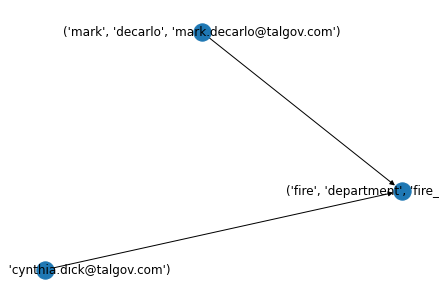

In [ ]:
grap = nx.DiGraph()
r = []
labeldict = {}
for i in range(len(nodes_2011_08)):
  display(i)
  r.append(i)
  labeldict[i] = nodes_2011_08[i]
grap.add_nodes_from(r)
grap.add_edges_from(edge_2011_08)
nx.draw(grap,labels=labeldict, with_labels=True)

In [ ]:
def disp_Graph(nodes,edges, title):
  G = nx.DiGraph()
  r = []
  labeldict = {}
  for i in range(len(nodes)):
    r.append(i)
    labeldict[i] = nodes[i]
  G.add_nodes_from(r)
  G.add_edges_from(edges)
  plt.figure()
  plt.title(title)
  nx.draw(G,labels=labeldict, with_labels=True)
  plt.show()

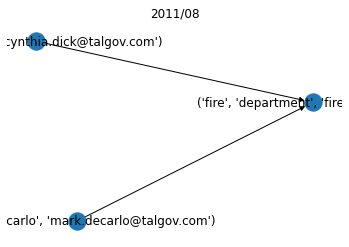

{(0, 1), (2, 1)}

In [ ]:
disp_Graph(nodes_2011_08, edge_2011_08, '2011/08')
display(edge_2011_08)

In [ ]:
for i in range(0,11):
  nodes_2012_01 = get_Unique_Nodes(month_2012[i])
  edges_2012_01 = make_edgelist(month_2012[i], nodes_2012_01)
  #display(nodes_2012_01)
  #display(edges_2012_01)
  #disp_Graph(nodes_2012_01,edges_2012_01)

['("m\'lisa", \'ingram\', \'mlisa.ingram@talgov.com\')',
 "('ann', 'wild', 'ann_wild')",
 "('beth', 'kirkland', 'bkirkland@taledc.com')",
 "('bill', 'behenna', 'bill_behenna')",
 "('carol', 'gerrell', 'carolyn.gerrell@talgov.com')",
 "('cathy', 'branch', 'catherine.branch@talgov.com')",
 "('cindy', 'cook', 'cindy_cook')",
 "('deborah', 'heiter', 'deborah.heiter@talgov.com')",
 "('f18020', 'l18020', 'brook.pace@deo.myflorida.com')",
 "('f496', 'l496', 'llaubscher@eflorida.com')",
 "('favors thompson, anita', '', 'anita.favors.thompson@talgov.com')",
 "('fred', 'goodrow', 'fred_goodrow')",
 "('gil', 'ziffer', 'gil@ziffberry.com')",
 "('holly', '', 'holly_')",
 "('jacqueline', 'hightower', 'jacqueline.hightower@talgov.com')",
 "('james', 'hosman', 'james_hosman')",
 "('jay', 'townsend', 'jay.townsend@talgov.com')",
 "('jim', 'english', 'james.english@talgov.com')",
 "('john', 'marks', 'john.marksiii@talgov.com')",
 "('jt', 'burnette', 'jt@inkbridge.com')",
 "('kara', 'palmer', 'kpalmer@ta

{(2, 8),
 (2, 9),
 (2, 15),
 (2, 19),
 (2, 22),
 (2, 25),
 (2, 33),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 16),
 (7, 17),
 (7, 18),
 (7, 20),
 (7, 21),
 (7, 23),
 (7, 24),
 (7, 25),
 (7, 26),
 (7, 27),
 (7, 28),
 (7, 29),
 (7, 30),
 (7, 31),
 (7, 32),
 (7, 34),
 (7, 35),
 (7, 36)}

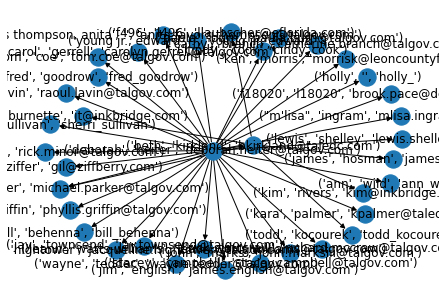

In [ ]:
nodes_2012_01 = get_Unique_Nodes(month_2012[0])
edges_2012_01 = make_edgelist(month_2012[0], nodes_2012_01)
display(nodes_2012_01)
display(edges_2012_01)
disp_Graph(nodes_2012_01,edges_2012_01)

In [ ]:
nodes_2012_02 = get_Unique_Nodes(month_2012[11])
edges_2012_02 = make_edgelist(month_2012[11], nodes_2012_02)
display(nodes_2012_02)
display(edges_2012_02)

IndexError: ignored

In [13]:
!echo "# GNN_CRA" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/manmclir/GNN_CRA.git
!git push -u origin main

Initialized empty Git repository in /content/.git/

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@a3ac64e07a39.(none)')
error: refname refs/heads/master not found
fatal: Branch rename failed
error: src refspec main does not match any.
error: failed to push some refs to 'https://github.com/manmclir/GNN_CRA.git'
